<a href="https://colab.research.google.com/github/jacheung/still-learning/blob/master/autocurator_CNN_v1_6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Import necessary libraries and set up image libraries in Google drive
import numpy as np
import scipy.io
import tensorflow as tf 
from tensorflow import keras
from sklearn.utils import class_weight
import sklearn.model_selection as ms

from google.colab import drive
import glob

import matplotlib.pyplot as plt

# Mount google drive and grab images and labels names 
drive.mount('/content/gdrive')
base_dir = "/content/gdrive/My Drive/Colab data/trialFramesNPY/"
T_class = glob.glob(base_dir + "*touchClass.mat")
frames = glob.glob(base_dir + "*dataset.mat")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


# 1) Data cleaning


## 1.1 Matching frames and labels

In [ ]:
# Trim frames and labels names to make the names the same to match them
frame_nums = []
T_class_nums = []

for i in range(len(frames)):
  frame_nums.append(frames[i][1:-11])

for i in range(len(T_class)):
  T_class_nums.append(T_class[i][1:-14])

In [ ]:
# Match and reorder all frames and label files
indices = []
T_class_reordered = []

for k in range(len(frame_nums)):
  indices.append([i for i, s in enumerate(T_class_nums) if frame_nums[k] in s])

indices = [x for x in indices if x != []]

for k in range(len(indices)):
    T_class_reordered.append(T_class[indices[k][0]])

# test that this is matched
print(T_class_reordered[-1])
print(frames[-1])

/content/gdrive/My Drive/Colab data/trialFramesNPY/AH0000x000000-29_touchClass.mat
/content/gdrive/My Drive/Colab data/trialFramesNPY/AH0000x000000-29_dataset.mat


In [ ]:
# load in labels and count how many data points are in each file. 
# each file represents a trial so for us this could be anywhere between 1 and 4000 data points. 
# most often somewhere between 200-600

raw_Y_set = []
frame_num_in_Y_set = []
for cnt1 in range(len(frames)):
  tmp2 = scipy.io.loadmat(T_class_reordered[cnt1])
  raw_Y_set.append(tmp2['touchClass'])
  frame_num_in_Y_set.append(len(raw_Y_set[cnt1]))

## 1.2 Build Keras Image Generator 
 

In [ ]:
# Function to generate an image tensor and corresponding label array
from psutil import virtual_memory
import sys
import time

def build_data( x_files, y_files) :
  to_del = 0
  start = time.time()

  cnt1 = -1;
  mem_free = 9999

  for k in range(len(y_files)):
    cnt1 = cnt1 + 1
    tmp1 = scipy.io.loadmat(x_files[cnt1])
    tmp2 = scipy.io.loadmat(y_files[cnt1])

    Xtmp = tmp1['finalMat']
    Ytmp = tmp2['touchClass']
    if cnt1==0:
      raw_X = Xtmp
      raw_Y = Ytmp
    else:

      raw_X = np.concatenate((raw_X,Xtmp), axis=0)
      raw_Y = np.concatenate((raw_Y,Ytmp), axis=0)
    if ((time.time() - start) > 2) or cnt1>=len(x_files)-1:# update every 2 seconds or when loop ends
      mem = virtual_memory()
      mem_free = mem.free/1024**3;
      start = time.time()

  return raw_X, raw_Y



make a custom class to help load in the data to prevent crashing due to over using RAM 
This class will 
- chunk the files based on the total frames contained in them based on "batch_size" variable 


In [ ]:
class My_Custom_Generator(keras.utils.Sequence) :
  
  def __init__(self, file_trial_list, file_Y_list, num_in_each, batch_size) :
    cnt = 0
    extract_inds = []
    # num_in_each contains the number of frames in each file I am loading, ie
    # for trial/file 1 there are 200 frames , trial/file 2 has 215 frames etc
    for k, elem in enumerate(num_in_each) :
      tot_frame_nums = sum(num_in_each[cnt: k+1]) # used to test if the number of frames in 
      # all these files exceded the "batch_size" limit 
      if tot_frame_nums>batch_size or len(num_in_each)-1 == k: # condition met, these files together 
      # meet the max requirment to load together as a batch 
        extract_inds.append([cnt, k+1])
        cnt = k+1 # reset to the current iter
        if np.diff(extract_inds[-1]) > 1: # if there is more than one file then we want to take off the last file 
        # because it excedes the set number of frames
          extract_inds[-1][-1] = extract_inds[-1][-1]-1
          cnt = cnt-1
    
    file_list_chunks = []
    file_Y_list_chunks = []
    for i, ii in enumerate(extract_inds):
      file_list_chunks.append(file_trial_list[ii[0]:ii[1]])
      file_Y_list_chunks.append(file_Y_list[ii[0]:ii[1]])


    self.file_trial_list = file_trial_list
    self.file_Y_list = file_Y_list
    self.batch_size = batch_size
    self.extract_inds = extract_inds
    self.num_in_each = num_in_each
    self.file_list_chunks = file_list_chunks
    self.file_Y_list_chunks = file_Y_list_chunks
    
  def __len__(self) :
    return len(self.extract_inds)
  
  def __getitem__(self, num_2_extract) :
    raw_X, raw_Y = build_data(self.file_list_chunks[num_2_extract], 
                          self.file_Y_list_chunks[num_2_extract])

    rgb_batch = np.repeat(raw_X[..., np.newaxis], 3, -1)
    IMG_SIZE = 96 # All images will be resized to 160x160. This is the size of MobileNetV2 input sizes

    rgb_tensor = tf.cast(rgb_batch, tf.float32) # convert to tf tensor with float32 dtypes
    rgb_tensor = (rgb_tensor/127.5) - 1 # /127.5 = 0:2, -1 = -1:1 requirement for mobilenetV2
    rgb_tensor = tf.image.resize(rgb_tensor, (IMG_SIZE, IMG_SIZE)) # resizing

    self.IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

    return rgb_tensor, raw_Y

  def get_single_trials(self, num_2_extract) :
      raw_X, raw_Y = build_data([self.file_trial_list[num_2_extract]], 
                            [self.file_Y_list[num_2_extract]])

      rgb_batch = np.repeat(raw_X[..., np.newaxis], 3, -1)
      IMG_SIZE = 96 # All images will be resized to 160x160. This is the size of MobileNetV2 input sizes

      rgb_tensor = tf.cast(rgb_batch, tf.float32) # convert to tf tensor with float32 dtypes
      rgb_tensor = (rgb_tensor/127.5) - 1 # /127.5 = 0:2, -1 = -1:1 requirement for mobilenetV2
      rgb_tensor = tf.image.resize(rgb_tensor, (IMG_SIZE, IMG_SIZE)) # resizing

      self.IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

      return rgb_tensor, raw_Y

In [ ]:
# Data splits to train/test/validation sets 

# *** need to get actual data split here
batch_size = 2000
validate_fraction = .3

# for now we will split based on num files not number of frames becasue its easier and shouldnt make
#  too much of a difference -- can fix later if we care to 
mixed_inds = np.random.choice(len(frames), len(frames), replace=False)
validate_count = round(validate_fraction*len(frames))
T_inds = mixed_inds[validate_count+1:-1]
# T_inds = [frames[k] for k in T_inds]
v_inds = mixed_inds[0:validate_count]
# v_inds = [frames[k] for k in v_inds]

my_training_batch_generator = My_Custom_Generator([frames[k] for k in T_inds], [T_class_reordered[k] for k in T_inds], [frame_num_in_Y_set[k] for k in T_inds],  batch_size)
my_validation_batch_generator = My_Custom_Generator([frames[k] for k in v_inds], [T_class_reordered[k] for k in v_inds], [frame_num_in_Y_set[k] for k in v_inds],  batch_size)


In [ ]:
len(frames)

131

#2) Exploratory Data Analysis

We're going to take a look at the distribution of classes and some sample images in randomly selected batches to ensure data quality.  

In [ ]:
# image transform from [-1 1] back to [0 255] for imshow
def image_transform(x):
  image = tf.cast((x + 1) * 127.5, tf.uint8)
  return image

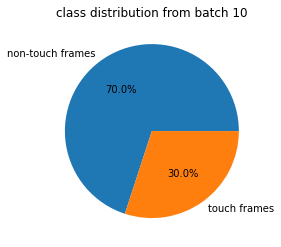

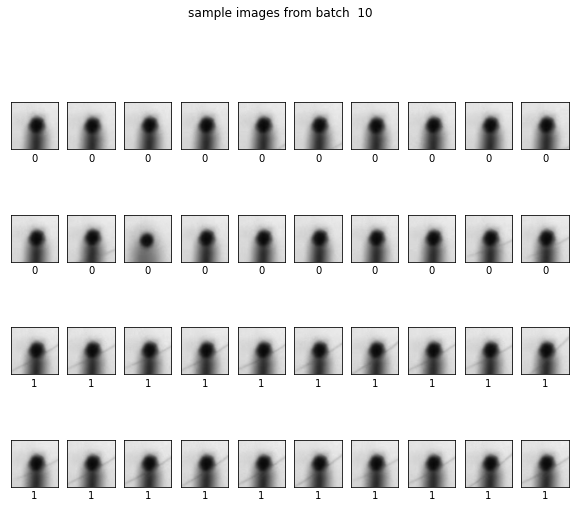

In [ ]:
# randomly select a batch and generate images and labels
batch_num = np.random.choice(np.arange(0,len(my_training_batch_generator.file_list_chunks)))
samp_x, samp_y = my_training_batch_generator.__getitem__(batch_num)

# look at the distribution of classes
plt.pie([1-np.mean(samp_y), np.mean(samp_y)],
        labels=['non-touch frames', 'touch frames'], autopct='%1.1f%%',)
plt.title('class distribution from batch ' + str(batch_num))
plt.show()

# generate indices for positive and negative classes
images_to_sample = 20
neg_class = [i for i, val in enumerate(samp_y) if val==0]
pos_class = [i for i, val in enumerate(samp_y) if val==1]
neg_index = np.random.choice(neg_class,images_to_sample)
pos_index = np.random.choice(pos_class,images_to_sample)

# plot sample positive and negative class images
plt.figure(figsize=(10,10))
for i in range(images_to_sample):
    plt.subplot(5,10,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    _ = plt.imshow(image_transform(samp_x[neg_index[i]]))
    plt.xlabel('0')

    plt.subplot(5,10,images_to_sample+i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(image_transform(samp_x[pos_index[i]]))
    plt.xlabel('1')
plt.suptitle('sample images from batch  ' + str(batch_num))
plt.show()

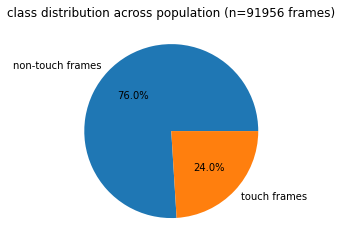

In [ ]:
# population distribution of data
batch_size = 2000
all_data_batch_generator = My_Custom_Generator(frames, T_class_reordered, frame_num_in_Y_set,  batch_size)
accumulator = []
x_y = []

for b in np.arange(0,len(all_data_batch_generator.file_list_chunks)):
  samp_x, samp_y = all_data_batch_generator.__getitem__(b)
  accumulator.append(len(samp_x))
  x_y.append([1-np.mean(samp_y), np.mean(samp_y)])

population = np.mean(np.array(x_y),axis=0)
plt.pie(population,
        labels=['non-touch frames', 'touch frames'], autopct='%1.1f%%',)
plt.title('class distribution across population (n=' + str(np.sum(accumulator)) + ' frames)')
plt.show()

# 3) Feature engineering?


In [ ]:
# Y vectorization and class weight calculation 
to_del = 0
start = time.time()

cnt1 = -1;
mem_free = 9999
y_files = my_training_batch_generator.file_Y_list
for k in range(len(y_files)):
  cnt1 = cnt1 + 1
  tmp2 = scipy.io.loadmat(y_files[cnt1])

  Ytmp = tmp2['touchClass']
  if cnt1==0:
    raw_Y_2 = Ytmp
  else:
    raw_Y_2 = np.concatenate((raw_Y_2,Ytmp), axis=0)


# 4) Deploy and selection of base model
In this section we're going to use MobileNetV2 as the base model.
We're going to run two variations of the model.  
a. basemodel with frozen layers and output classifer changes   
b. basemodel with final 100 layers unfrozen to optimize prediction 


In [ ]:
# Create base model 

# First, instantiate a MobileNet V2 model pre-loaded with weights trained on ImageNet. By specifying the include_top=False argument, 
# you load a network that doesn't include the classification layers at the top, which is ideal for feature extraction

# Create the base model from the pre-trained model MobileNet V2
IMG_SIZE = 96 # All images will be resized to 160x160. This is the size of MobileNetV2 input sizes
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

base_model.trainable = False

feature_batch = base_model.output
print(feature_batch.shape)

# Adding Classification head
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

prediction_layer = tf.keras.layers.Dense(1, activation='sigmoid')
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

# Model Stacking
model = tf.keras.Sequential([
  base_model,
  global_average_layer,
  prediction_layer
])

print(model.summary())

# Compile model with specific metrics
# Metrics below are for evaluating imbalanced datasets
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name = 'auc')
]

base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=METRICS)

9412608/9406464 [==============================] - 0s 0us/step
(None, 3, 3, 1280)
(None, 1280)
(None, 1)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_96 (Functio (None, 3, 3, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1281      
Total params: 2,259,265
Trainable params: 1,281
Non-trainable params: 2,257,984
_________________________________________________________________
None


In [ ]:
import time 
start = time.time()

# Fit model with a couple parameters
EPOCHS = 20

# Class imbalance weighting
rebalance = class_weight.compute_class_weight('balanced',
                                  [0, 1], raw_Y_2.flatten())
class_weights = {i : rebalance[i] for i in range(2)}

# Early stopping 
callbacks = [keras.callbacks.EarlyStopping (monitor = 'val_loss',
                                            patience = 2)]

history = model.fit(my_training_batch_generator, epochs=EPOCHS,
              validation_data= my_validation_batch_generator,
              callbacks = callbacks,
              class_weight = class_weights)


total_seconds = time.time() - start
print('total time took ' + str(round(total_seconds/60)), ' minutes')

Epoch 1/20
39/39 [==============================] - 100s 3s/step - loss: 0.8308 - tp: 3779.0000 - fp: 19652.0000 - tn: 33094.0000 - fn: 11424.0000 - precision: 0.1613 - recall: 0.2486 - auc: 0.3172 - val_loss: 0.7618 - val_tp: 2786.0000 - val_fp: 9062.0000 - val_tn: 8521.0000 - val_fn: 3824.0000 - val_precision: 0.2351 - val_recall: 0.4215 - val_auc: 0.4088
Epoch 2/20
39/39 [==============================] - 25s 645ms/step - loss: 0.7216 - tp: 6582.0000 - fp: 21441.0000 - tn: 31305.0000 - fn: 8621.0000 - precision: 0.2349 - recall: 0.4329 - auc: 0.4878 - val_loss: 0.7019 - val_tp: 4332.0000 - val_fp: 8342.0000 - val_tn: 9241.0000 - val_fn: 2278.0000 - val_precision: 0.3418 - val_recall: 0.6554 - val_auc: 0.6178
Epoch 3/20
39/39 [==============================] - 25s 632ms/step - loss: 0.6315 - tp: 9707.0000 - fp: 17290.0000 - tn: 35456.0000 - fn: 5496.0000 - precision: 0.3596 - recall: 0.6385 - auc: 0.7171 - val_loss: 0.6250 - val_tp: 5065.0000 - val_fp: 5990.0000 - val_tn: 11593.0000 

## 4.1) Model learning evaluation 

Here we'll look at metrics of loss, AUC, precision, and recall across epochs of learning 

 

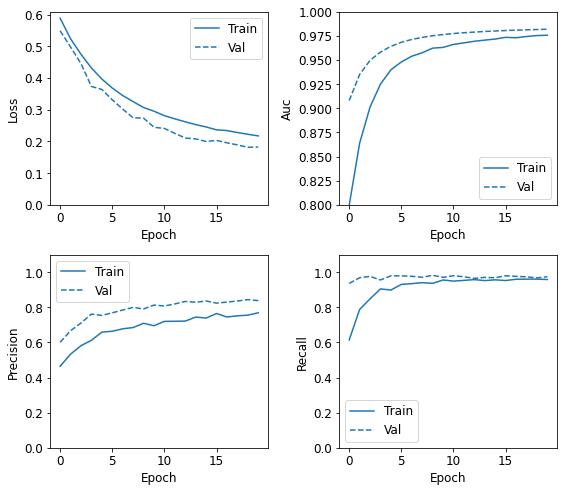

In [ ]:
# Overall model evaluation
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
def plot_metrics(history):
  metrics =  ['loss', 'auc', 'precision', 'recall']
  fig = plt.figure(figsize=(8, 7))
  plt.rcParams.update({'font.size':12})
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch,  history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1.1])

    plt.legend()
    plt.tight_layout()

plot_metrics(history)

array([[0.22275435, 0.0667921 ],
       [0.00957838, 0.70087517]])

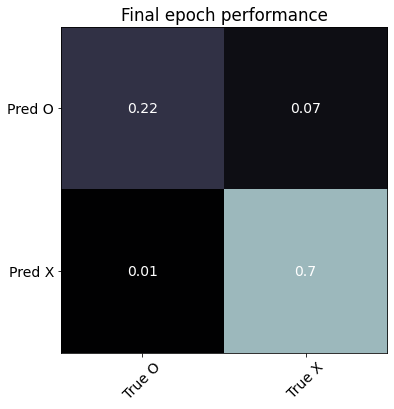

In [ ]:
# Confusion matrix last epoch 
def plot_confusion_matrix(history, epoch):
  fig = plt.figure(figsize = (6,6))
  plt.rcParams.update({'font.size':14})
  plt.tight_layout()

  total_samples= history.history['tp'][epoch] + history.history['fp'][epoch] + history.history['tn'][epoch] + history.history['fn'][epoch]
  values = np.array([[history.history['tp'][epoch], history.history['fp'][epoch]],
                      [history.history['fn'][epoch], history.history['tn'][epoch]]]) / total_samples
  for i in range(2):
      for j in range(2):
          text = plt.text(j, i, round(values[i, j],2),
                        ha="center", va="center", color="w")

  im = plt.imshow(values,cmap='bone',vmin=0, vmax=1)
  plt.yticks([0,1],labels=['Pred O', 'Pred X'])
  plt.xticks([0,1],labels = ['True O', 'True X'],rotation=45)
  plt.title('Final epoch performance')
  plt.show
  return values

plot_confusion_matrix(history,-1)

<function matplotlib.pyplot.show>

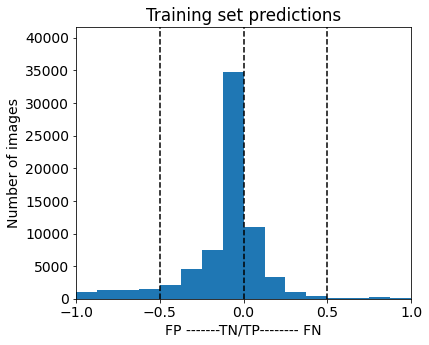

In [ ]:
# load all validation data and get distribution of probability differences
accumulator = np.array([])
for batch_num in np.arange(0,len(my_training_batch_generator.file_list_chunks)):
  dmatx, dmaty = my_training_batch_generator.__getitem__(batch_num)
  # predict using the trained model and calculate difference from target
  # prob_diff: positive values are false negatives, negative values are false positives 
  predy = model.predict(dmatx)
  prob_diff = dmaty - predy
  accumulator = np.concatenate((accumulator,prob_diff[:,0]))

plt.figure(figsize=(6,5))
plt.xlim([-1, 1])
plt.xticks(np.linspace(-1,1,5))
plt.xlabel('FP -------TN/TP-------- FN')
plt.ylabel('Number of images')
plt.title('Training set predictions')
l = plt.hist(accumulator,bins=np.linspace(-1,1,17))
for k in np.array([-.5,0,.5]):
  plt.plot([k, k],[0, max(l[0])*1.2],color='k',linestyle='--')
plt.ylim([0, max(l[0])*1.2])
plt.show

<function matplotlib.pyplot.show>

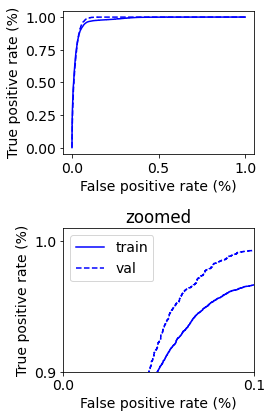

In [ ]:
# ROC Analysis
from sklearn.metrics import roc_curve

def calculate_roc(batch_generator):
  y_pred = np.array([])
  y_true = np.array([])

  for batch_num in np.arange(0,len(batch_generator.file_list_chunks)):
    dmat_x, dmat_y = batch_generator.__getitem__(batch_num)
    # predict using the trained model and calculate difference from target
    # prob_diff: positive values are false negatives, negative values are false positives 
    pred_y = model.predict(dmat_x)
    y_true = np.concatenate((y_true, dmat_y[:,0]))
    y_pred = np.concatenate((y_pred,pred_y[:,0]))

  fpr, tpr, thresholds = roc_curve(y_true, y_pred)

  return fpr, tpr, thresholds

train_fp, train_tp, train_thresh = calculate_roc(my_training_batch_generator)
val_fp, val_tp, val_thresh = calculate_roc(my_validation_batch_generator)

fig,axs = plt.subplots(2,1,figsize=(4,6))
axs[0].plot(train_fp,train_tp,color = 'b',label = 'train')
axs[0].plot(val_fp,val_tp, color = 'b', linestyle="--", label = 'val')
axs[0].set_xlabel('False positive rate (%)')
axs[0].set_ylabel('True positive rate (%)')

axs[1].plot(train_fp,train_tp,color = 'b',label = 'train')
axs[1].plot(val_fp,val_tp, color = 'b', linestyle="--", label = 'val')
axs[1].set_ylim(.9, 1.01)
axs[1].set_xlim(0, .1)
axs[1].set_xticks([0, .3])
axs[1].set_yticks([.7, 1])
axs[1].set_title('zoomed')
axs[1].set_xlabel('False positive rate (%)')
axs[1].set_ylabel('True positive rate (%)')

plt.tight_layout()
plt.legend()
plt.show

## 4.2) Model evaluation of failed images

Here we'll plot 10 images of the False Positive and False Negative cases in each batch. This will help us see what the extreme cases of false negatives and false positives are. 

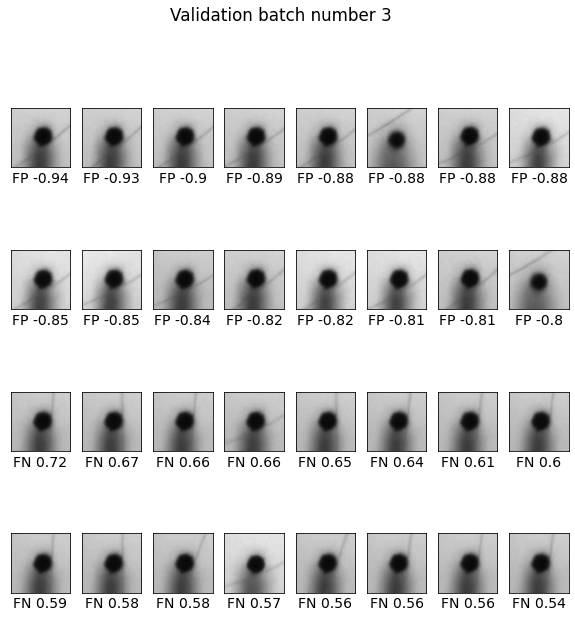

In [ ]:
# load a batch of data
batch_num = np.random.choice(np.arange(0,len(my_validation_batch_generator.file_list_chunks)))
dmatx, dmaty = my_validation_batch_generator.__getitem__(batch_num)

# predict using the trained model and calculate difference from target
# prob_diff: positive values are false negatives, negative values are false positives 
predy = model.predict(dmatx)
prob_diff = dmaty - predy

# sorted indices and values for plotting
idx = np.argsort(prob_diff.flatten())
values = np.sort(prob_diff.flatten()).round(2)

images_to_sample = 16

plt.figure(figsize=(10,10))
for i in range(images_to_sample):
    plt.subplot(4,images_to_sample/2,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    _ = plt.imshow(image_transform(dmatx[idx[i]]))
    plt.xlabel('FP ' + str(values[i]))

    plt.subplot(4,images_to_sample/2,images_to_sample+i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(image_transform(dmatx[idx[-i -1]]))
    plt.xlabel('FN ' + str(values[-i -1]))

plt.suptitle('Validation batch number ' + str(batch_num))
plt.show()

# 5) Hyperparameter tuning 
 Here we'll loosen up a couple of the top layers for training to see if we can boost performance 

"In most convolutional networks, the higher up a layer is, the more specialized it is. The first few layers learn very simple and generic features that generalize to almost all types of images. As you go higher up, the features are increasingly more specific to the dataset on which the model was trained. The goal of fine-tuning is to adapt these specialized features to work with the new dataset, rather than overwrite the generic learning"

In [ ]:
# Fine-tuning model by unfreezing layers and allowing them to be trainable

model.trainable = True

# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 50

# Freeze all the layers before the `fine_tune_at` layer
for layer in model.layers[:fine_tune_at]:
  layer.trainable =  False

# Compile model with specific metrics
# Metrics below are for evaluating imbalanced datasets
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name = 'auc')
]

# compile model with a much slower learning rate 
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=base_learning_rate/10),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=METRICS)


NameError: ignored

In [ ]:
start = time.time()

# Fit model with a couple parameters
EPOCHS = 20

# Class imbalance weighting
rebalance = class_weight.compute_class_weight('balanced',
                                  [0, 1], raw_Y_2.flatten())
class_weights = {i : rebalance[i] for i in range(2)}

# Early stopping 
callbacks = [keras.callbacks.EarlyStopping (monitor = 'val_loss',
                                            patience = 2)]

history = model.fit(my_training_batch_generator, epochs=EPOCHS,
              validation_data= my_validation_batch_generator,
              callbacks = callbacks,
              class_weight = class_weights)

total_seconds = time.time() - start
print('total time took ' + str(round(total_seconds/60)), ' minutes')

Epoch 1/20
38/38 [==============================] - 25s 656ms/step - loss: 0.2337 - tp: 15596.0000 - fp: 4986.0000 - tn: 48872.0000 - fn: 704.0000 - precision: 0.7577 - recall: 0.9568 - auc: 0.9738 - val_loss: 0.1822 - val_tp: 5104.0000 - val_fp: 812.0000 - val_tn: 12604.0000 - val_fn: 168.0000 - val_precision: 0.8627 - val_recall: 0.9681 - val_auc: 0.9836
Epoch 2/20
38/38 [==============================] - 23s 610ms/step - loss: 0.2337 - tp: 15596.0000 - fp: 4986.0000 - tn: 48872.0000 - fn: 704.0000 - precision: 0.7577 - recall: 0.9568 - auc: 0.9738 - val_loss: 0.1822 - val_tp: 5104.0000 - val_fp: 812.0000 - val_tn: 12604.0000 - val_fn: 168.0000 - val_precision: 0.8627 - val_recall: 0.9681 - val_auc: 0.9836
Epoch 3/20
38/38 [==============================] - 23s 607ms/step - loss: 0.2337 - tp: 15596.0000 - fp: 4986.0000 - tn: 48872.0000 - fn: 704.0000 - precision: 0.7577 - recall: 0.9568 - auc: 0.9738 - val_loss: 0.1822 - val_tp: 5104.0000 - val_fp: 812.0000 - val_tn: 12604.0000 - val

# ---- DONE ---- 

In [ ]:
class_predict = []
is_val_data = []
for n, trial_name in enumerate(my_validation_batch_generator.file_trial_list):
  # print(n)
  dmatx, dmaty = my_validation_batch_generator.get_single_trials(n)
  tmp1= model.predict(dmatx)
  class_predict.append(tmp1)
  is_val_data.append(1)
for n, trial_name in enumerate(my_training_batch_generator.file_trial_list):
  # print(n)
  dmatx, dmaty = my_training_batch_generator.get_single_trials(n)
  tmp1= model.predict(dmatx)
  class_predict.append(tmp1)
  is_val_data.append(0)


In [ ]:
all_files = my_validation_batch_generator.file_trial_list + my_training_batch_generator.file_trial_list
tmp1 = [all_files, class_predict, is_val_data]
scipy.io.savemat('/content/gdrive/My Drive/Colab data/cellALL6.mat', mdict={'my_list': tmp1})

In [ ]:
len(my_validation_batch_generator.file_trial_list)

39